# Washington DC Housing Price Prediction Model

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import statsmodels.api as sm

from sklearn import metrics
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

# Data Cleaning and Preparation

In [84]:
# Importing Dataset
house = pd.read_csv('DC_Properties.csv', index_col=0) 

C:\Users\Fredd\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3526: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [85]:
# Droping ID, single value, redundant columns
house.drop(columns=["CITY", "STATE", "X", "Y"], inplace=True)

In [86]:
# Showing Dataset
house.head()

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,...,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,QUADRANT
0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,...,18S UJ 23061 09289,38.914680,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,NW
1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,...,18S UJ 23067 09289,38.914683,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,NW
2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,...,18S UJ 23074 09289,38.914684,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,NW
3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,1984,...,18S UJ 23078 09288,38.914683,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,NW
4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,1985,...,18S UJ 23188 09253,38.914383,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,NW


In [87]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158957 entries, 0 to 158956
Data columns (total 44 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   BATHRM              158957 non-null  int64  
 1   HF_BATHRM           158957 non-null  int64  
 2   HEAT                158957 non-null  object 
 3   AC                  158957 non-null  object 
 4   NUM_UNITS           106696 non-null  float64
 5   ROOMS               158957 non-null  int64  
 6   BEDRM               158957 non-null  int64  
 7   AYB                 158686 non-null  float64
 8   YR_RMDL             80928 non-null   float64
 9   EYB                 158957 non-null  int64  
 10  STORIES             106652 non-null  float64
 11  SALEDATE            132187 non-null  object 
 12  PRICE               98216 non-null   float64
 13  QUALIFIED           158957 non-null  object 
 14  SALE_NUM            158957 non-null  int64  
 15  GBA                 106696 non-nul

There are two types of properties in the data set (Residential) 67% and (Condominium) 33%, and they have such a distinctive pattern that separate studies need to be done. At this time, the study focuses on (Residential) type which is majority of observations.

In [88]:
# Removing the Condominium type
house = house.drop(house[house['SOURCE'] == 'Condominium'].index)

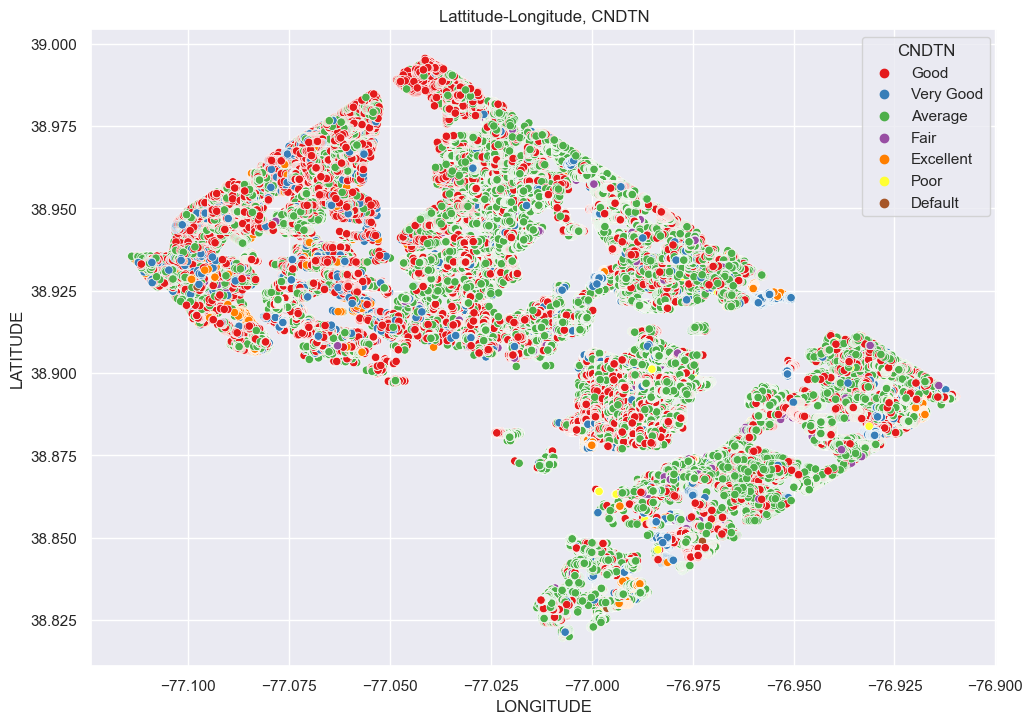

In [89]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(y=house['LATITUDE'],x=house['LONGITUDE'],hue=house['CNDTN'],palette='Set1').set_title('Lattitude-Longitude, CNDTN', )

plt.show()

In [90]:
# Droping ID, single value, redundant columns (update)
house.drop(columns=['NUM_UNITS', 'AYB','YR_RMDL', 'EYB','STORIES','HEAT','SALEDATE', 'STYLE','STRUCT', 'GRADE','EXTWALL', 'ROOF','INTWALL', 'CMPLX_NUM', 'LIVING_GBA','FULLADDRESS','QUADRANT','WARD','SQUARE', 'CENSUS_TRACT','CENSUS_BLOCK', 'ASSESSMENT_NBHD','ASSESSMENT_SUBNBHD', 'NATIONALGRID','GIS_LAST_MOD_DTTM','SOURCE','QUALIFIED','CNDTN'], inplace=True)

In [91]:
# Droping ID, single value, redundant columns (update)
house.drop(columns=['SALE_NUM','BLDG_NUM','USECODE','LANDAREA','ZIPCODE','LATITUDE','LONGITUDE'], inplace=True)

In [92]:
# Remove all NaN values
house.dropna(inplace = True)
house.head()

,BATHRM,HF_BATHRM,AC,ROOMS,BEDRM,PRICE,GBA,KITCHENS,FIREPLACES
0,4,0,Y,8,4,1095000.0,2522.0,2.0,5
2,3,1,Y,9,5,2100000.0,2522.0,2.0,4
3,3,1,Y,8,5,1602000.0,2484.0,2.0,3
5,3,2,Y,10,5,1950000.0,5344.0,1.0,4
7,3,1,Y,8,4,1050000.0,2401.0,2.0,1


In [93]:
# Changing Variables to int64 
house['PRICE'] = house['PRICE'].astype(np.int64)
house['GBA'] = house['GBA'].astype(np.int64)
house['KITCHENS'] = house['KITCHENS'].astype(np.int64)

In [94]:
# Showing Dataset (update)
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57899 entries, 0 to 106695
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   BATHRM      57899 non-null  int64 
 1   HF_BATHRM   57899 non-null  int64 
 2   AC          57899 non-null  object
 3   ROOMS       57899 non-null  int64 
 4   BEDRM       57899 non-null  int64 
 5   PRICE       57899 non-null  int64 
 6   GBA         57899 non-null  int64 
 7   KITCHENS    57899 non-null  int64 
 8   FIREPLACES  57899 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 4.4+ MB


In [95]:
# Changing AC from Yes and No to 1 and 0
varlist =  ['AC']

# Defining the map function
def binary_map(x):
    return x.map({'Y': 1, "N": 0})

# Applying the function to the housing list
house[varlist] = house[varlist].apply(binary_map)

In [96]:
# Showing Dataset (update)
house.dropna(inplace = True)
house.head()

,BATHRM,HF_BATHRM,AC,ROOMS,BEDRM,PRICE,GBA,KITCHENS,FIREPLACES
0,4,0,1.0,8,4,1095000,2522,2,5
2,3,1,1.0,9,5,2100000,2522,2,4
3,3,1,1.0,8,5,1602000,2484,2,3
5,3,2,1.0,10,5,1950000,5344,1,4
7,3,1,1.0,8,4,1050000,2401,2,1


[Text(0.5, 1.0, 'Correlation Matrix of Dataset')]

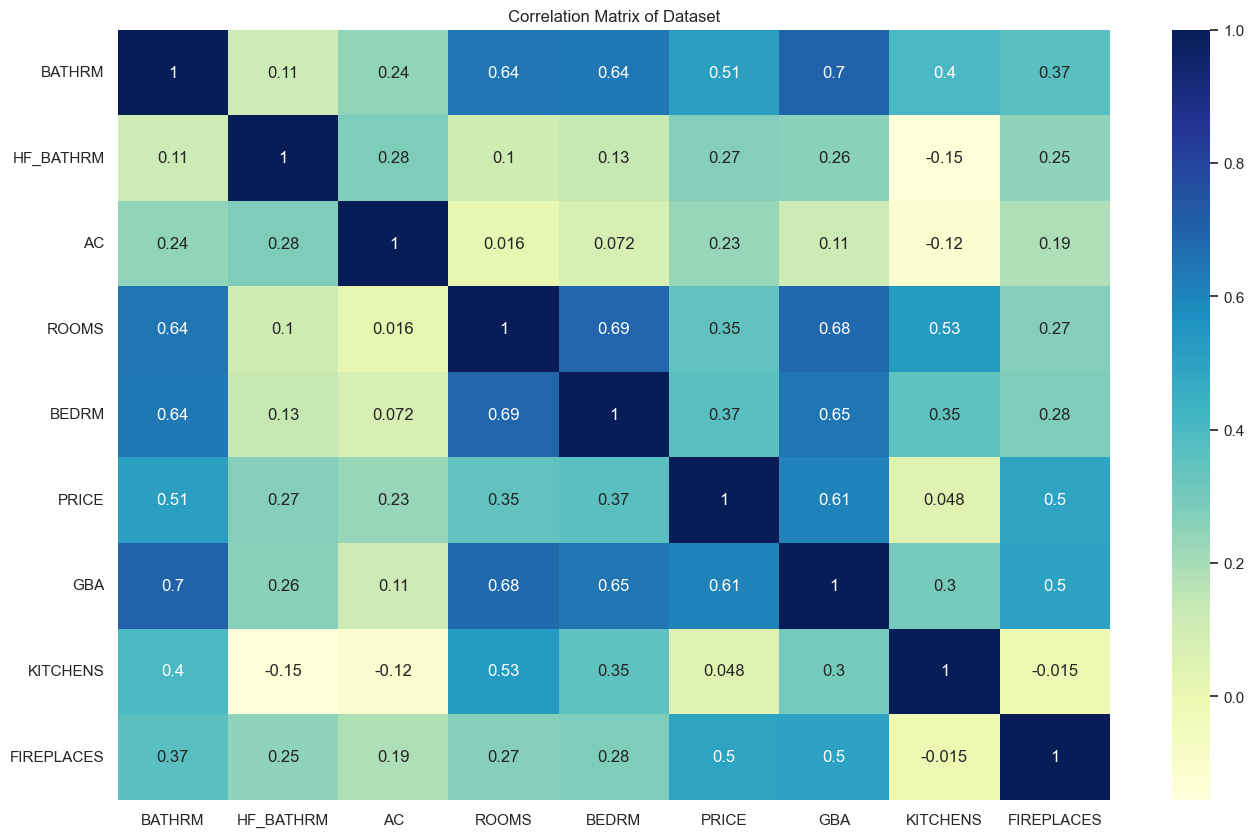

In [97]:
# Heatmap of the dataset
plt.figure(figsize = (16,10))    
sns.heatmap(house.corr(),annot = True, cmap="YlGnBu").set(title='Correlation Matrix of Dataset')

[Text(0.5, 1.0, 'Price vs GBA( Area )'),
 Text(0.5, 0, 'Area (in square feet)'),
 Text(0, 0.5, 'Price ( in ten millions )')]

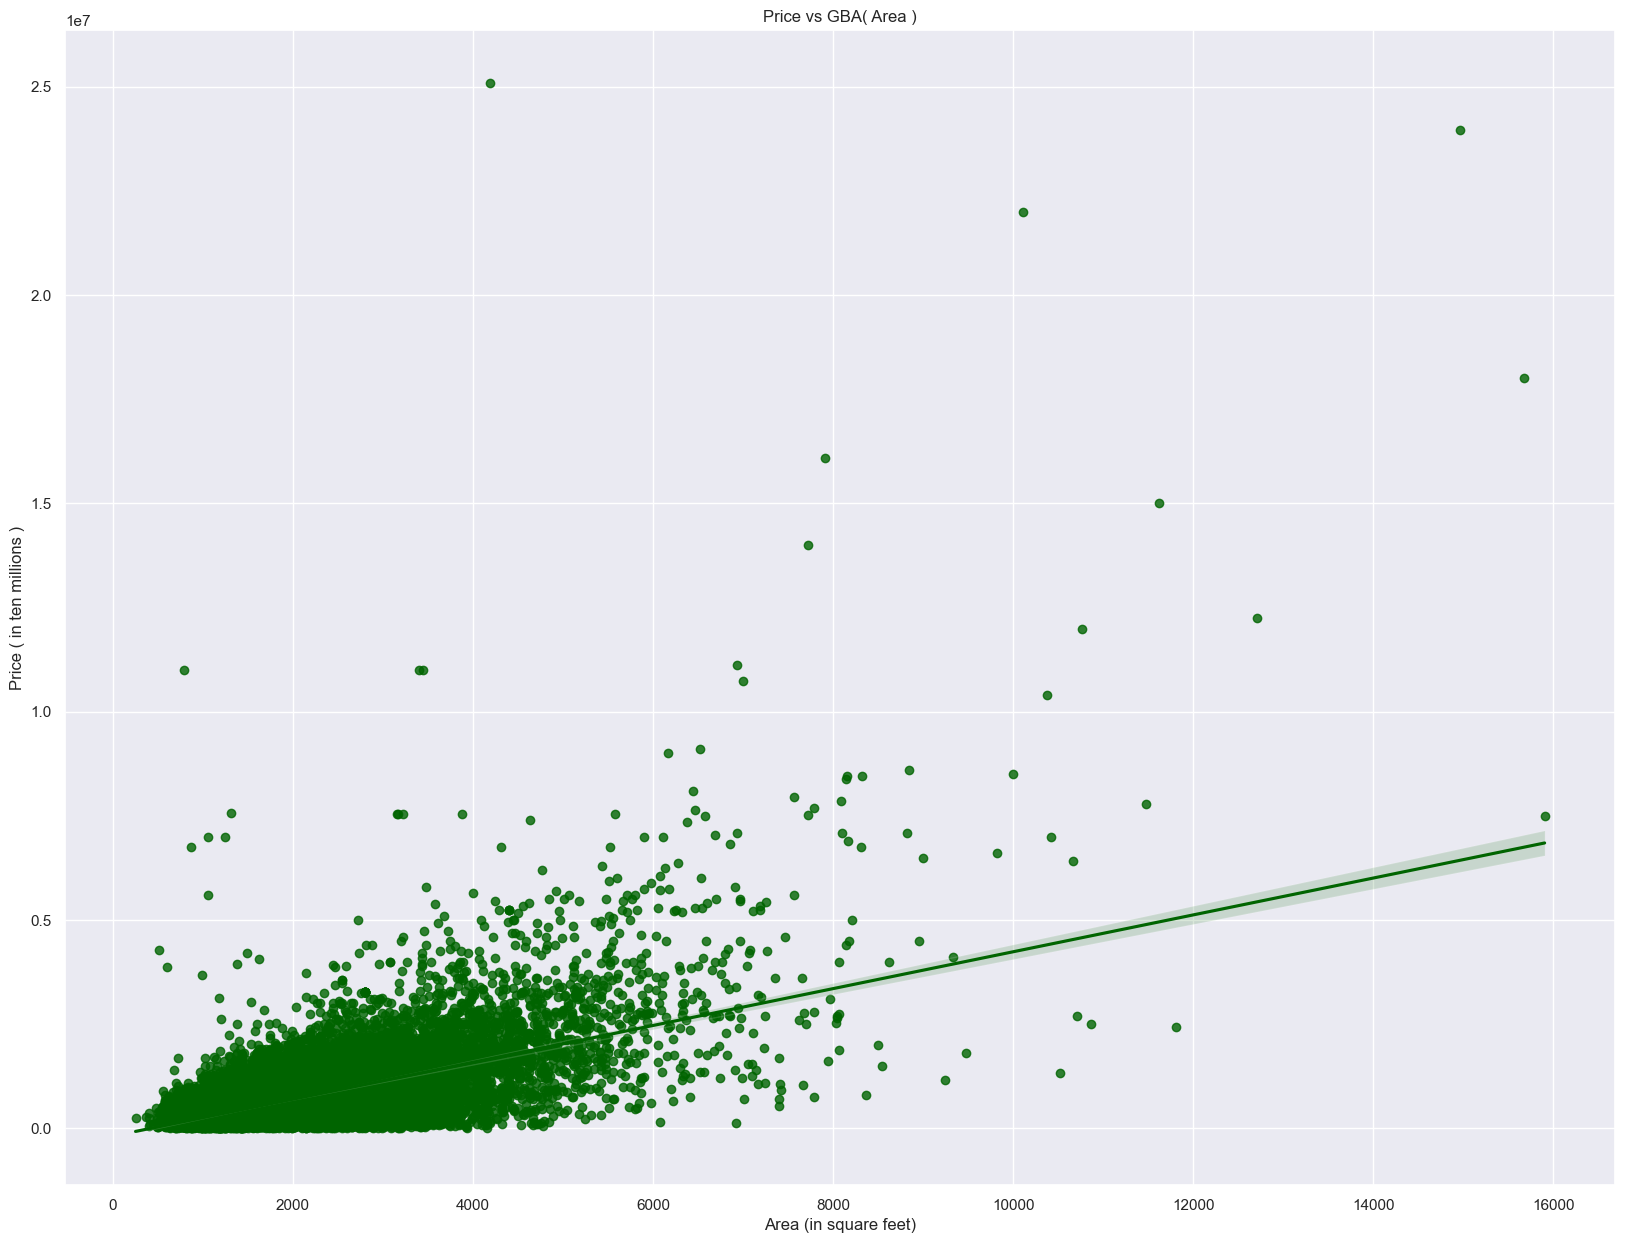

In [98]:
# Scatter plot of Price vs GBA( Area )
sns.set(rc={"figure.figsize":(20, 15)})
sns.regplot(house, x = 'GBA' , y = 'PRICE', color = "darkgreen").set(title='Price vs GBA( Area )', xlabel = 'Area (in square feet)', ylabel='Price ( in ten millions )')

# Linear Regression Model

Mean Squared Error: 161909480776.3755
R-squared: 0.507350696043305
VarScore: 0.5073756136635419 


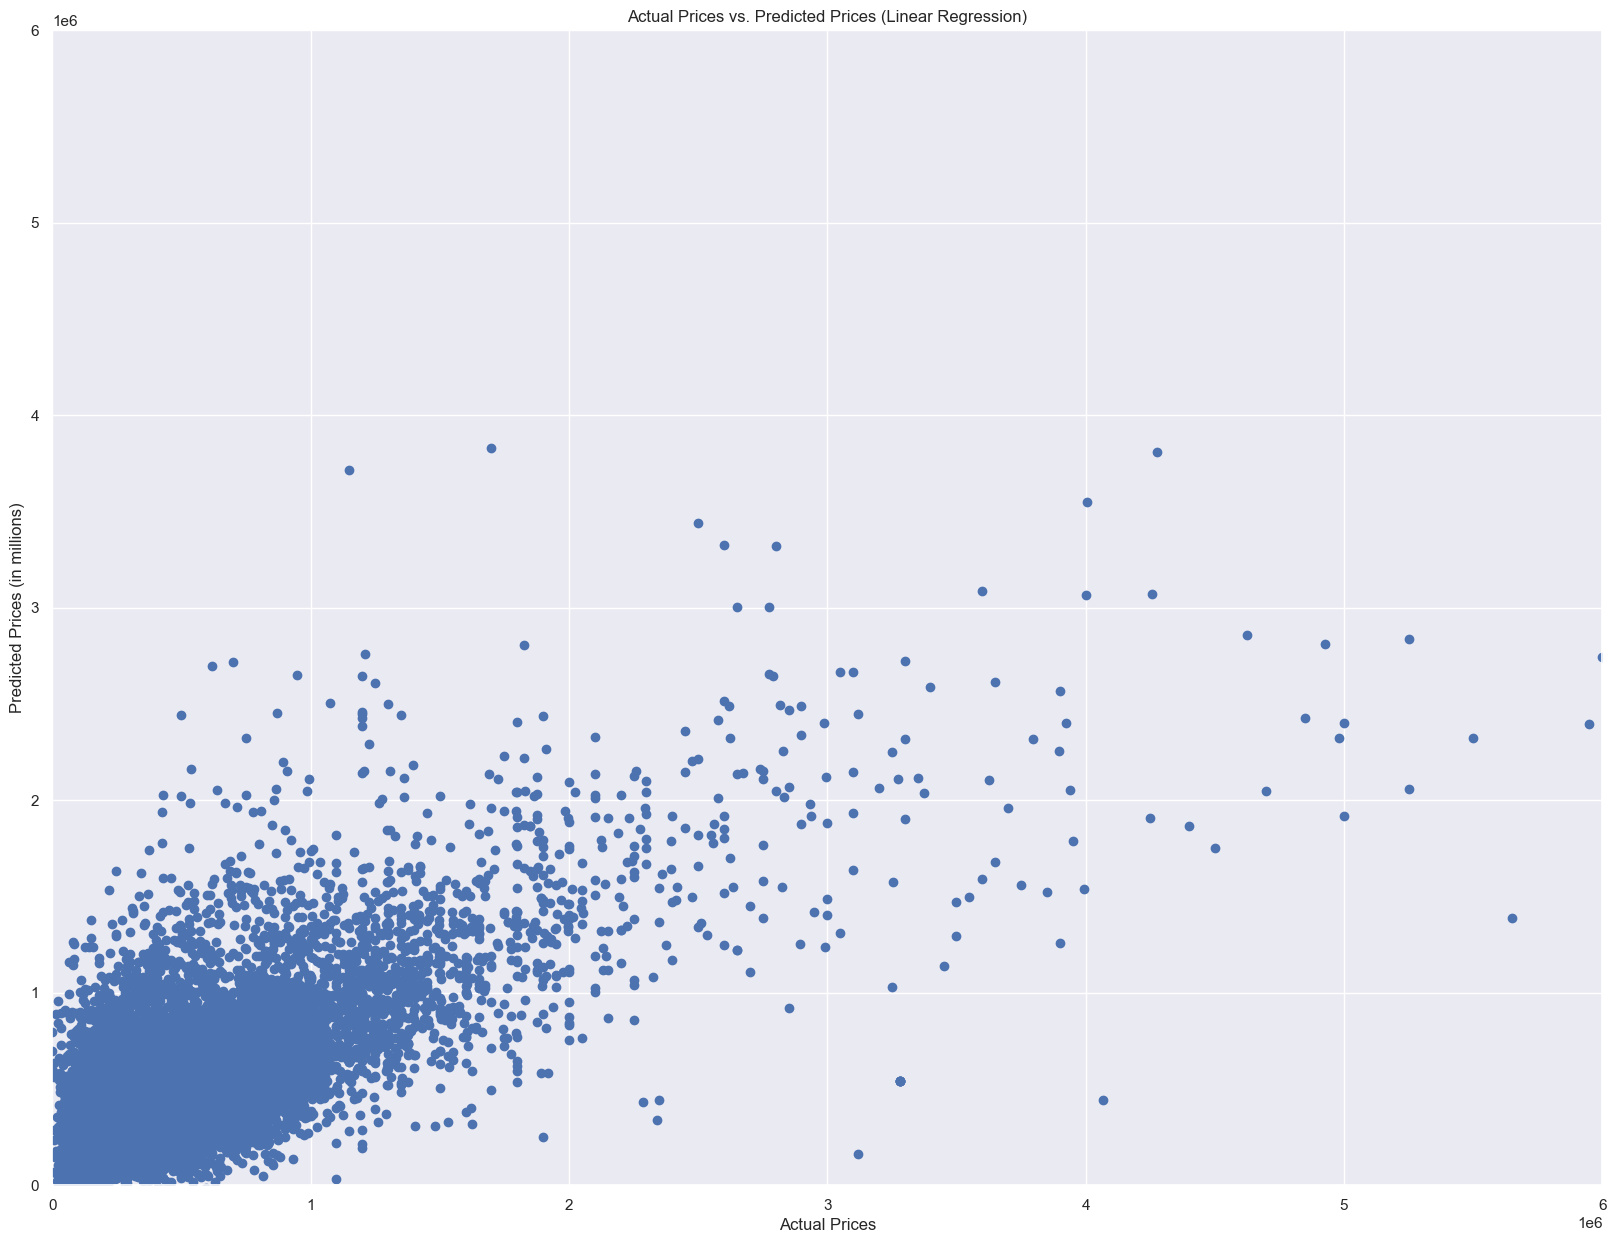

In [99]:
data = house

selected_features = ['GBA', 'BATHRM', 'HF_BATHRM', 'AC','FIREPLACES', 'ROOMS', 'BEDRM', 'KITCHENS']  
X = data[selected_features]
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

rfe = RFE(model, n_features_to_select=8)

X_train_rfe = rfe.fit_transform(X_train, y_train)

model.fit(X_train_rfe, y_train)

X_test_rfe = rfe.transform(X_test)
y_pred = model.predict(X_test_rfe)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
Vs = metrics.explained_variance_score(y_test,y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'VarScore: {Vs} ')

plt.scatter(y_test, y_pred)
plt.xlim(0,6000000)
plt.ylim(0,6000000)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices (in millions)")
plt.title("Actual Prices vs. Predicted Prices (Linear Regression)")
plt.show()

# Building model using statsmodel, for Linear Regression (OLS Model)

In [100]:
# OLS Model
data = house

X = data[['GBA', 'BATHRM', 'HF_BATHRM', 'AC','FIREPLACES', 'ROOMS', 'BEDRM', 'KITCHENS'] ]
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ols_model = sm.OLS(y_train, X_train).fit()

print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  PRICE   R-squared (uncentered):                   0.715
Model:                            OLS   Adj. R-squared (uncentered):              0.715
Method:                 Least Squares   F-statistic:                          1.449e+04
Date:                Sun, 03 Dec 2023   Prob (F-statistic):                        0.00
Time:                        23:11:17   Log-Likelihood:                     -6.6820e+05
No. Observations:               46305   AIC:                                  1.336e+06
Df Residuals:                   46297   BIC:                                  1.336e+06
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Random Forest Method

Mean Squared Error: 162449767178.2307
R-squared: 0.5057067421591042
VarScore: 0.5057541638427402 


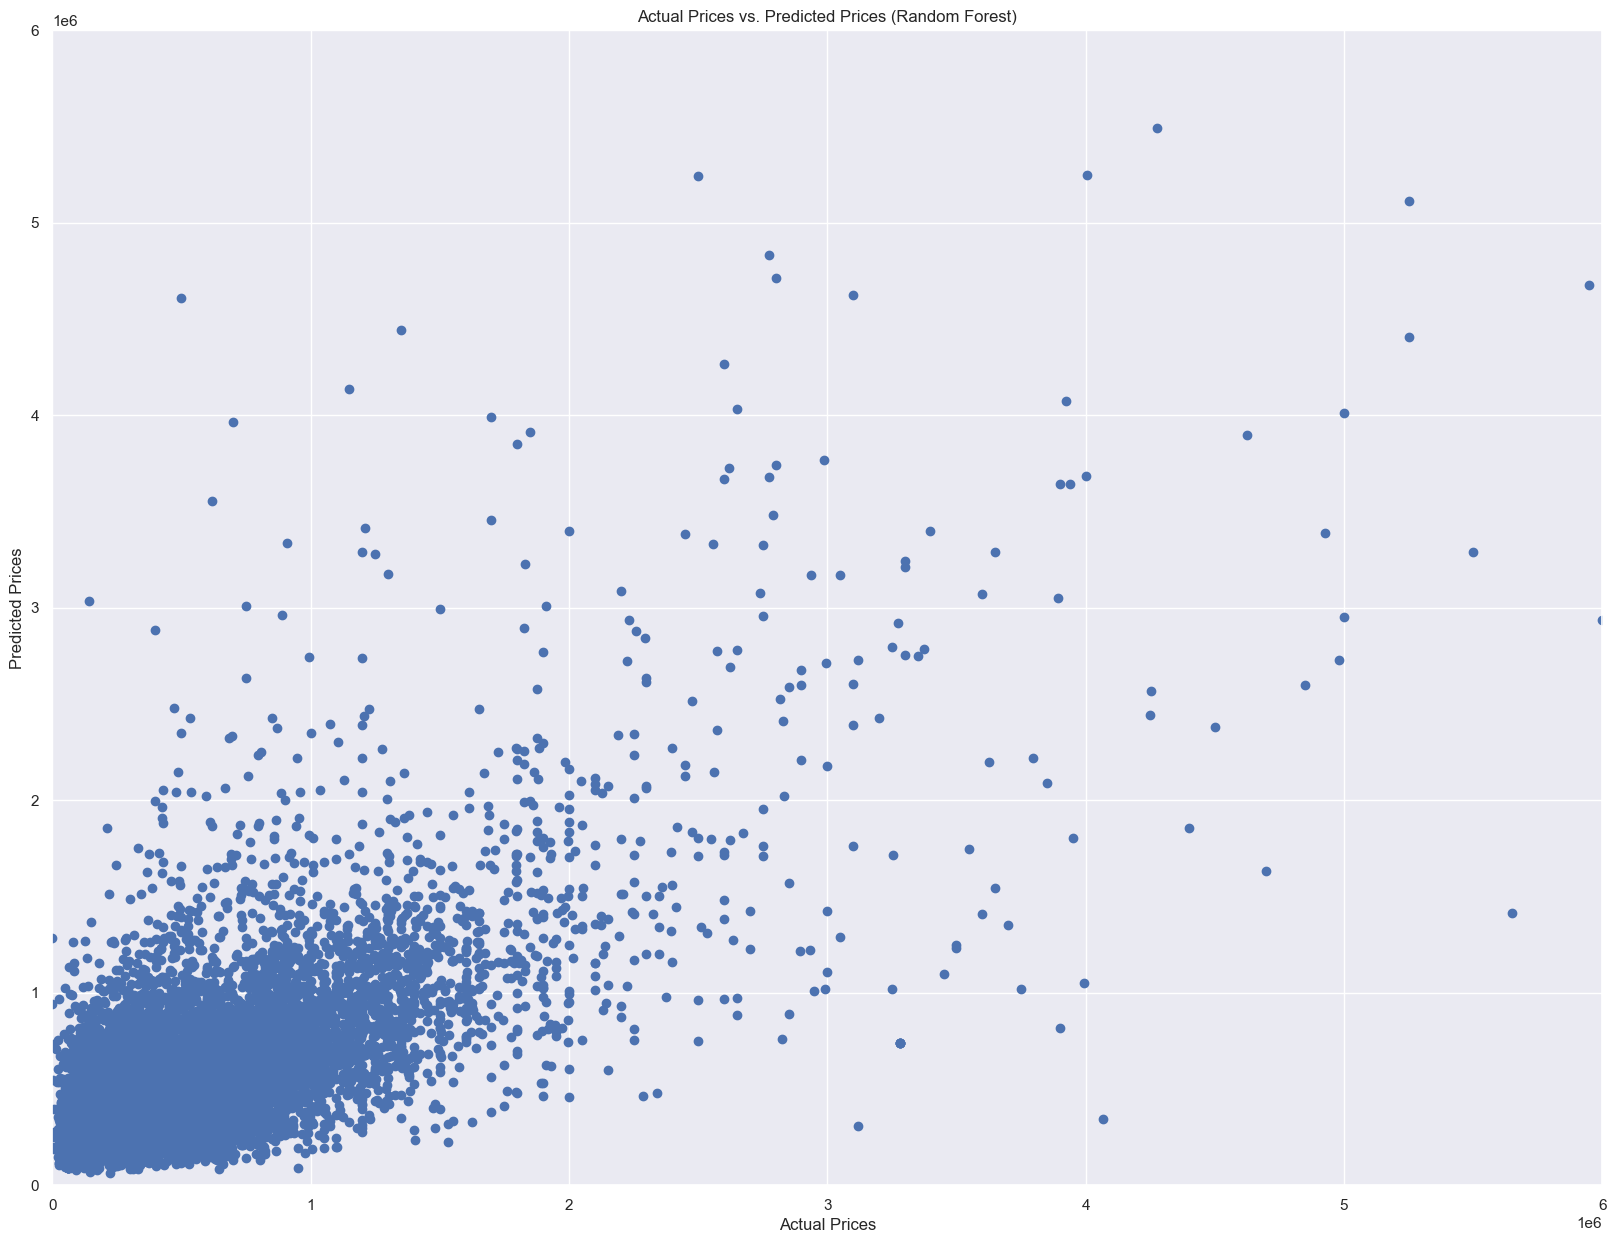

In [101]:
# Random Forest Method
data = house

selected_features = ['GBA', 'BATHRM', 'HF_BATHRM', 'AC','FIREPLACES', 'ROOMS', 'BEDRM', 'KITCHENS']  
X = data[selected_features]
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
Vs = metrics.explained_variance_score(y_test,y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'VarScore: {Vs} ')

plt.scatter(y_test, y_pred)
plt.xlim(0,6000000)
plt.ylim(0,6000000)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Prices vs. Predicted Prices (Random Forest)")
plt.show()


# K-Fold Cross-Validation for both models

In [21]:
# K-Fold Cross-Validation for linear Regression Model
kf = KFold(n_splits= 5, shuffle=True, random_state=42)

cv_r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)

print(f'R-squared (Cross-Validation): {cv_r2_scores}')

R-squared (Cross-Validation): [0.5073507  0.44897158 0.46613677 0.47502106 0.42813222]


In [22]:
# K-Fold Cross-Validation for Random Forest Model
kf = KFold(n_splits= 5, shuffle=True, random_state=42)

cv_r2_scores = cross_val_score(rf_model, X, y, scoring='r2', cv=kf)

print(f'R-squared (Cross-Validation): {cv_r2_scores}')

R-squared (Cross-Validation): [0.51225134 0.4457066  0.43563949 0.48703384 0.39108857]


# Grid Search CV for both models

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score

In [28]:
# Grid Search CV for Liner Regression Model

data = house

selected_features = ['GBA', 'BATHRM', 'HF_BATHRM', 'AC', 'ROOMS', 'BEDRM', 'KITCHENS','FIREPLACES']
X = data[selected_features]
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

scorer = make_scorer(r2_score)

grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring=scorer, cv=5)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best R-squared Score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
print(f'R-squared on Test Set: {r2_test}')

Best Parameters:  {'fit_intercept': True, 'positive': False}
Best R-squared Score:  0.45507199938941484
R-squared on Test Set: 0.5073506960433051


In [29]:
# Grid Search CV for Random Forest Model

data = house

selected_features = ['GBA', 'BATHRM', 'HF_BATHRM', 'AC', 'ROOMS', 'BEDRM', 'KITCHENS','FIREPLACES']
X = data[selected_features]
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

scorer = make_scorer(r2_score)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=scorer, cv=5)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best R-squared Score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
print(f'R-squared on Test Set: {r2_test}')


Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best R-squared Score:  0.5015531740655774
R-squared on Test Set: 0.5812527173001412
